# Mauna Loa CO2 Dataset

Atmospheric CO2 concentration data - classic time series with trend and seasonality


In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from src.experiments import run_exact_proj_svgp, run_multiple_seeds, run_d_m_sweep_with_frontier,run_sweep_d_multiple_seeds, repeat_spherical_runs_for_d
from src.config import TrainCfg, SVGPcfg
from src.kernels import SM_kernel, stable_matern_kernel, stable_rbf_kernel, long_periodic_plus_short_rbf
from src.utils.plotting import plot_reliability_projected_gp, plot_resampling_policy_comparison, plot_multiscale_comparison



## Data Preprocessing


loaded 2225 CO2 measurements from 1958-03-29 00:00:00 to 2001-12-29 00:00:00


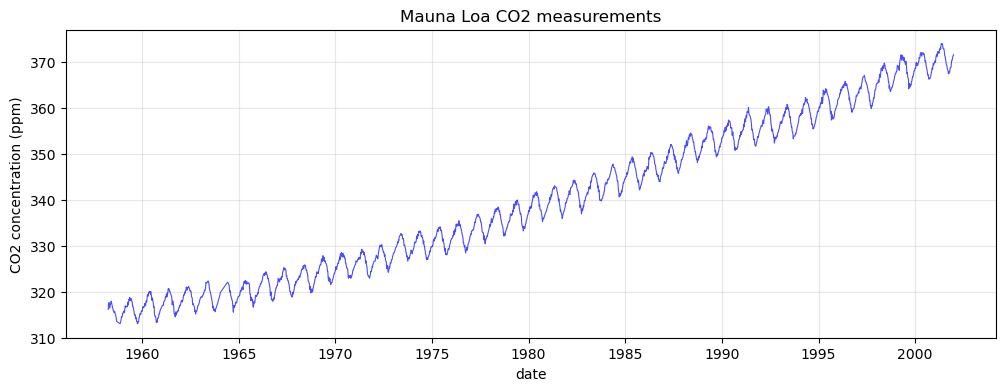

In [2]:
# load and preprocess data
co2 = fetch_openml(data_id=41187, as_frame=True, parser='auto')
df = co2.frame[["year", "month", "day", "co2"]].copy()

# clean and make a pandas datetime
df = df.dropna(subset=["year", "month", "day", "co2"])
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["day"] = df["day"].astype(int)
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=df["day"]), errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date")

# filter out sentinel/missing values if present
df = df[df["co2"] > 0].reset_index(drop=True)

print(f"loaded {len(df)} CO2 measurements from {df['date'].min()} to {df['date'].max()}")

# quick plot of raw data
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["co2"], 'b-', alpha=0.7, linewidth=0.8)
plt.xlabel("date")
plt.ylabel("CO2 concentration (ppm)")
plt.title("Mauna Loa CO2 measurements")
plt.grid(alpha=0.3)
plt.show()


In [3]:
# 1D input: time in fractional years from start
t0 = df["date"].min()
x_all = (df["date"] - t0).dt.days.values.astype(np.float32) / 365.25  # years since start
y_all = df["co2"].values.astype(np.float32)

TEST_FRAC = 0.2
rng = np.random.default_rng(0)
perm = rng.permutation(len(x_all))
x_all = x_all[perm]
y_all = y_all[perm]

n = len(x_all)
n_train = int(round((1.0 - TEST_FRAC) * n))
x_train_co2_np = x_all[:n_train]
y_train_co2_np = y_all[:n_train]
x_test_co2_np  = x_all[n_train:]
y_test_co2_np  = y_all[n_train:]

print(f"train points: {len(x_train_co2_np)}, test points: {len(x_test_co2_np)}")

# plot grid across the full span
x_plot_co2 = np.linspace(x_all.min(), x_all.max(), 400).astype(np.float32)

x_train_co2 = torch.tensor(x_train_co2_np, dtype=torch.float32).unsqueeze(-1)
y_train_co2 = torch.tensor(y_train_co2_np, dtype=torch.float32)
x_test_co2  = torch.tensor(x_test_co2_np,  dtype=torch.float32).unsqueeze(-1)
y_test_co2  = torch.tensor(y_test_co2_np,  dtype=torch.float32)


train points: 1780, test points: 445


## GP Regression with Spectral Mixture Kernel - 2 mixtures



running exact GP training | iters=500 lr=0.05 lbfgs=False jitter=0.0001
[exact] iter=0000 loss=12.871117 Delta=inf ||grad||=1.31e+01
noise=0.0954 |raw_noise|grad=0.05539065599441528
[exact] iter=0100 loss=2.469258 Delta=4.64e-02 ||grad||=6.83e-01
noise=0.0945 |raw_noise|grad=0.012704438529908657
[exact] iter=0200 loss=2.148605 Delta=3.11e-03 ||grad||=1.90e-01
noise=0.098 |raw_noise|grad=0.006957363802939653
[exact] iter=0300 loss=2.002922 Delta=1.60e-02 ||grad||=8.93e-02
noise=0.0983 |raw_noise|grad=0.0036168363876640797
[exact] iter=0400 loss=1.950059 Delta=1.61e-02 ||grad||=9.96e-02
noise=0.0951 |raw_noise|grad=0.007757673971354961
[exact] done | time=61.64s best_loss=1.807548

running spherical GP training | iters=500 lr=0.05 d=300 jitter=0.0001
[proj ] iter=0000 loss=2202.056641 Delta=inf ||grad||=2.99e+02
noise=0.1 |raw_noise|grad=10.3136625289917
[proj ] iter=0100 loss=1435.745728 Delta=3.69e+00 ||grad||=8.16e+01
noise=0.155 |raw_noise|grad=6.694320201873779
[proj ] iter=0200 lo

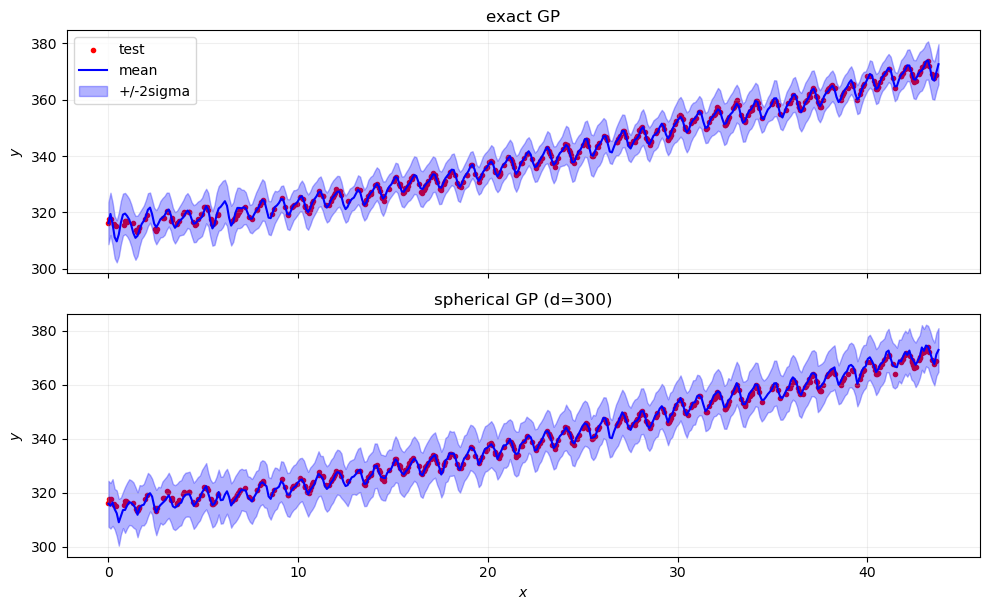

In [5]:
torch.manual_seed(1)
np.random.seed(1)

d_proj = 300
res_exact_co2, res_proj_co2, res_svgp_co2 = run_exact_proj_svgp(
    x_train_co2, y_train_co2,
    x_test_co2, y_test_co2,
    d_proj=d_proj, num_mixtures=2,
    x_plot=x_plot_co2,
    add_svgp=False, init_hyps_data=False,
    cfg=TrainCfg(resample_every=20, mean_cfg="linear", lr=0.05), keep_exact=True,
    svgp_cfg=SVGPcfg(m_inducing=256, steps=500, mean_cfg="linear"),
    # savepath='../results/mauna_loa_co2_d300_two_mixtures.png'
)


## Multiple seeds

In [9]:
# Quick multiple seeds analysis
results_multiple_seeds_quick = run_multiple_seeds(
    x_train_co2, y_train_co2, x_test_co2, y_test_co2,
    k=5,
    d_proj=300,
    num_mixtures=2,
    cfg=TrainCfg(
        lr=0.05,
        patience=50,
        resample_every=20,
        mean_cfg="linear",
        verbose=False
    ),
    svgp_cfg=SVGPcfg(
        m_inducing=128,
        steps=300,
        lr_hyp=1e-2,
        lr_ngd=0.05,
        patience=50,
        verbose=False
    ),
    add_svgp=True,
    init_hyps_data=False,
    use_multiscale=False,
    keep_exact=True,
    base_seed=0
)

Running 5 seeds: 100%|██████████| 5/5 [06:27<00:00, 77.57s/it]


=== Summary of 5 runs ===
Base seed: 0
Projection dimension: 300
Number of mixtures: 2
Multi-scale: False
Exact GP included: True
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 1.6138 ± 0.8981
spherical_NLPD: 2.3919 ± 0.1447
spherical_COV95: 99.6854 ± 0.7035
spherical_time: 23.7158 ± 9.2731
exact_RMSE: 0.8512 ± 0.0690
exact_NLPD: 2.0345 ± 0.0223
exact_COV95: 100.0000 ± 0.0000
exact_time: 46.2694 ± 1.3349
SVGP_RMSE: 1.4295 ± 0.0835
SVGP_NLPD: 2.4437 ± 0.1995
SVGP_COV95: 75.2809 ± 1.8935
SVGP_time: 7.4683 ± 0.3146


## Frontier plot


Running 5 combined experiments with 5 seeds each
d_values: [5, 40, 200, 800, 1800], m_values: [50, 100, 200, 400, 800]
Including exact GP: True

Running exact GP once (deterministic, independent of d/m values)...
Exact GP RMSE: 0.779519, Time: 48.59s


Combined experiments:  20%|██        | 1/5 [01:09<04:39, 69.98s/it]


=== Summary of 5 runs ===
Base seed: 0
Projection dimension: 5
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 1.8033 ± 0.9009
spherical_NLPD: 6.4830 ± 9.9142
spherical_COV95: 82.8764 ± 35.7863
spherical_time: 6.0007 ± 2.2072
SVGP_RMSE: 9.8459 ± 0.1520
SVGP_NLPD: 74.7809 ± 4.4509
SVGP_COV95: 69.1236 ± 1.3065
SVGP_time: 7.9351 ± 0.1301


Combined experiments:  40%|████      | 2/5 [03:01<04:43, 94.45s/it]


=== Summary of 5 runs ===
Base seed: 10000
Projection dimension: 40
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 1.4874 ± 1.0409
spherical_NLPD: 2.2369 ± 0.1872
spherical_COV95: 99.1910 ± 1.6861
spherical_time: 11.9919 ± 6.2981
SVGP_RMSE: 1.6940 ± 0.0473
SVGP_NLPD: 2.8519 ± 0.0849
SVGP_COV95: 72.0899 ± 1.5842
SVGP_time: 10.2656 ± 0.2497


Combined experiments:  60%|██████    | 3/5 [05:42<04:09, 124.66s/it]


=== Summary of 5 runs ===
Base seed: 20000
Projection dimension: 200
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 1.6549 ± 0.9929
spherical_NLPD: 4.9857 ± 6.0343
spherical_COV95: 86.6067 ± 29.6972
spherical_time: 15.6881 ± 6.0372
SVGP_RMSE: 0.5860 ± 0.0158
SVGP_NLPD: 0.7874 ± 0.0073
SVGP_COV95: 95.1910 ± 0.1231
SVGP_time: 16.3665 ± 0.5470


Combined experiments:  80%|████████  | 4/5 [11:02<03:22, 202.10s/it]


=== Summary of 5 runs ===
Base seed: 30000
Projection dimension: 800
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 0.8174 ± 0.2166
spherical_NLPD: 2.3848 ± 0.0640
spherical_COV95: 100.0000 ± 0.0000
spherical_time: 33.1362 ± 9.0513
SVGP_RMSE: 0.4156 ± 0.0052
SVGP_NLPD: 0.5418 ± 0.0076
SVGP_COV95: 96.8090 ± 0.2930
SVGP_time: 30.9404 ± 2.1954


Combined experiments: 100%|██████████| 5/5 [24:01<00:00, 288.24s/it]



=== Summary of 5 runs ===
Base seed: 40000
Projection dimension: 1800
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: True

=== Metrics Summary ===
spherical_RMSE: 0.7583 ± 0.0984
spherical_NLPD: 2.4405 ± 0.0175
spherical_COV95: 100.0000 ± 0.0000
spherical_time: 49.1567 ± 1.3166
SVGP_RMSE: 0.3723 ± 0.0011
SVGP_NLPD: 0.4637 ± 0.0020
SVGP_COV95: 98.1573 ± 0.1005
SVGP_time: 106.3524 ± 5.7444

=== Projection Results (Mean RMSE, Median Time) ===
      d      rmse       time
0     5  1.803268   5.356275
1    40  1.487388   9.460219
2   200  1.654911  18.398303
3   800  0.817427  38.758212
4  1800  0.758286  49.417309

=== SVGP Results (Mean RMSE, Median Time) ===
     m      rmse        time
0   50  9.845930    7.960859
1  100  1.694006   10.170164
2  200  0.585961   16.290613
3  400  0.415647   29.860302
4  800  0.372254  104.793745

=== Exact GP Results (Single run, deterministic) ===
       rmse      time
0  0.779519  48.58513
1  0.779519  48.58513
2  0.7

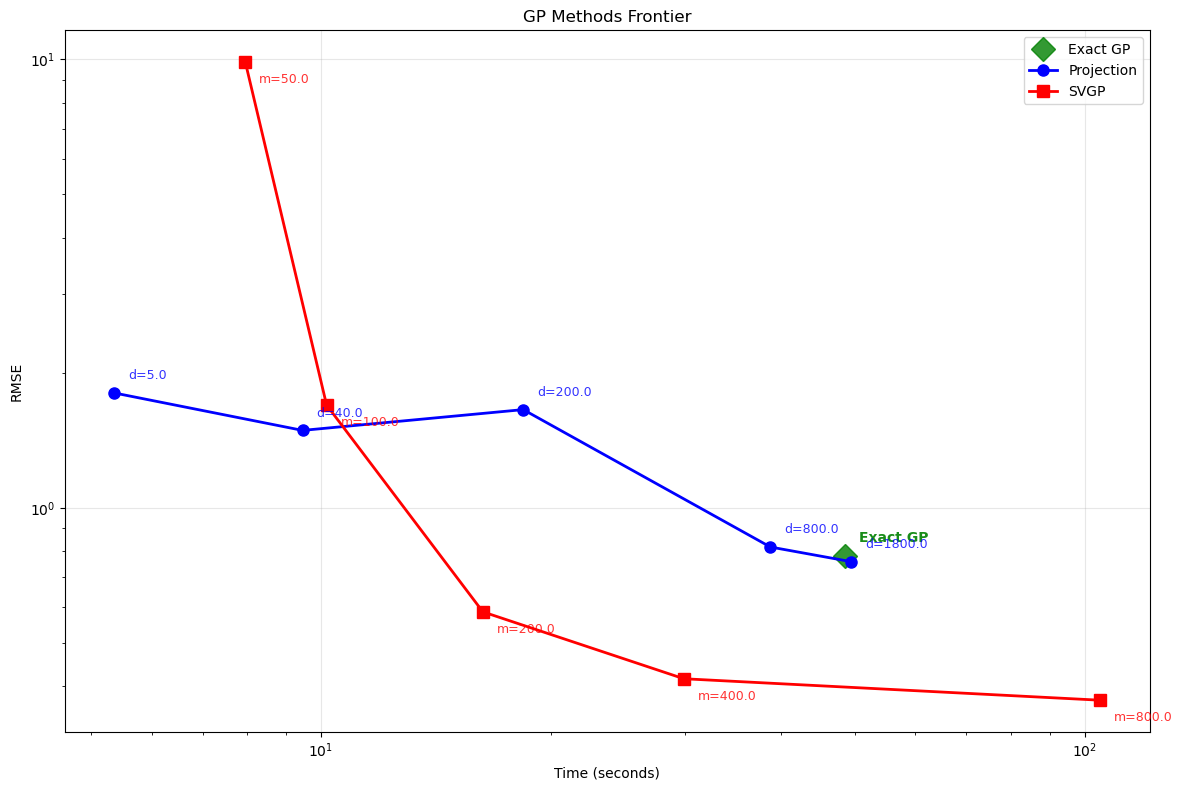

In [10]:
torch.manual_seed(1)
np.random.seed(1)

results = run_d_m_sweep_with_frontier(x_train_co2, y_train_co2, x_test_co2, y_test_co2, num_mixtures=2,
        d_values=[5, 40, 200, 800, 1800],
        cfg=TrainCfg(verbose=False, resample_every=20, mean_cfg="linear", lr=0.05),
        svgp_cfg=SVGPcfg(verbose=False, m_inducing=256, steps=500, mean_cfg="linear")
)


## Ablations

### Sweep Over D Values


Sweeping d values:  20%|██        | 1/5 [00:33<02:13, 33.25s/it]


=== Summary of 5 runs ===
Base seed: 0
Projection dimension: 5
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 2.1823 ± 1.2996
spherical_NLPD: 13.7202 ± 16.6156
spherical_COV95: 67.6854 ± 40.4602
spherical_time: 6.5955 ± 3.0393


Sweeping d values:  40%|████      | 2/5 [01:35<02:31, 50.43s/it]


=== Summary of 5 runs ===
Base seed: 10000
Projection dimension: 100
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 2.1562 ± 1.1449
spherical_NLPD: 7.1146 ± 9.8140
spherical_COV95: 76.1798 ± 34.0622
spherical_time: 12.4298 ± 6.0678


Sweeping d values:  60%|██████    | 3/5 [03:40<02:49, 84.58s/it]


=== Summary of 5 runs ===
Base seed: 20000
Projection dimension: 300
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 1.4309 ± 0.8347
spherical_NLPD: 2.3754 ± 0.1029
spherical_COV95: 100.0000 ± 0.0000
spherical_time: 24.9757 ± 6.1549


Sweeping d values:  80%|████████  | 4/5 [07:01<02:10, 130.26s/it]


=== Summary of 5 runs ===
Base seed: 30000
Projection dimension: 1000
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 0.7985 ± 0.2092
spherical_NLPD: 2.4134 ± 0.0533
spherical_COV95: 100.0000 ± 0.0000
spherical_time: 39.9648 ± 6.4752


Sweeping d values: 100%|██████████| 5/5 [11:49<00:00, 141.93s/it]



=== Summary of 5 runs ===
Base seed: 40000
Projection dimension: 2500
Number of mixtures: 2
Multi-scale: False
Exact GP included: False
SVGP included: False

=== Metrics Summary ===
spherical_RMSE: 0.9998 ± 0.2981
spherical_NLPD: 2.4480 ± 0.0386
spherical_COV95: 100.0000 ± 0.0000
spherical_time: 57.5508 ± 5.8688

Results averaged over 5 seeds:
      RMSE_mean  RMSE_std  COV95_mean  COV95_std  NLPD_mean   NLPD_std  \
d                                                                        
5      2.182272  1.299618   67.685393  40.460173  13.720202  16.615610   
100    2.156150  1.144869   76.179775  34.062183   7.114574   9.813986   
300    1.430901  0.834718  100.000000   0.000000   2.375423   0.102888   
1000   0.798498  0.209173  100.000000   0.000000   2.413400   0.053322   
2500   0.999784  0.298053  100.000000   0.000000   2.447954   0.038588   

      time_sec_mean  time_sec_std  
d                                  
5          6.595496      3.039320  
100       12.429787      6

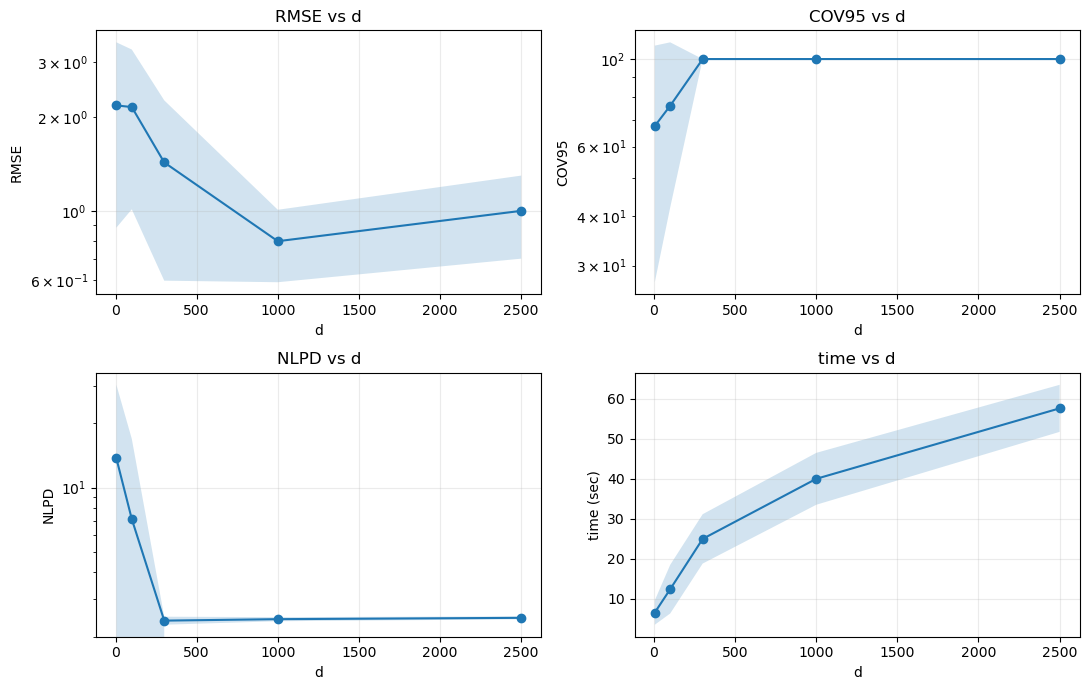


best d=1000 (RMSE=0.7985+/-0.2092, COV95=100.0000+/-0.0000, NLPD=2.4134+/-0.0533, time=39.96+/-6.48s)


In [ ]:
# sweep and aggregate
d_list = [5, 100, 300, 1000, 2500]
df_agg, reps_for_best, runs_raw = run_sweep_d_multiple_seeds(
    x_train_co2, y_train_co2, x_test_co2, y_test_co2,
    d_list=d_list,
    n_seeds=5,
    num_mixtures=2,
    cfg=TrainCfg(max_iter=500, patience=40, lr=0.05, verbose=False, mean_cfg="linear"),
    init_hyps_data=False,
    savepath='../results/d_sweep_metrics.png'
)


### Resampling Policy Comparison

Running resampling policy comparison:
  d_values: [50, 300]
  resample_policies: [None, 30, 5]
  n_seeds: 10

Testing d=50, no resampling
  RMSE: 3.4591 ± 0.4989
  NLPD: 8.9384 ± 2.2873

Testing d=50, every-30
  RMSE: 1.7252 ± 1.1021
  NLPD: 6.9043 ± 7.5029

Testing d=50, every-5
  RMSE: 1.3001 ± 0.6467
  NLPD: 2.2055 ± 0.1281

Testing d=300, no resampling
  RMSE: 3.0490 ± 0.7935
  NLPD: 5.2958 ± 3.1608

Testing d=300, every-30
  RMSE: 0.9654 ± 0.2437
  NLPD: 2.3887 ± 0.0884

Testing d=300, every-5
  RMSE: 0.7845 ± 0.1378
  NLPD: 2.4076 ± 0.0521


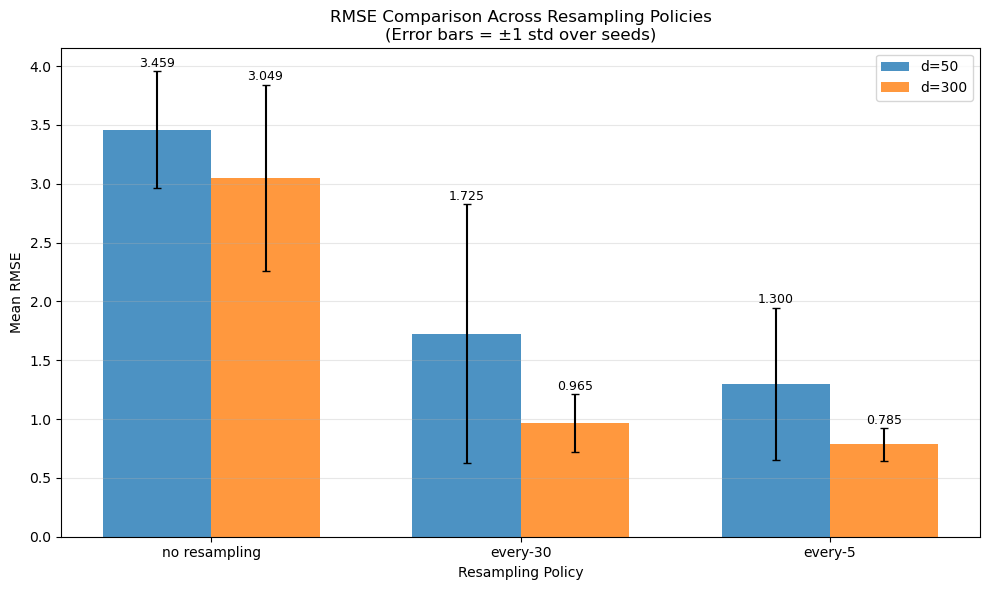


SUMMARY TABLE
  d resample_policy  rmse_mean  rmse_std  nlpd_mean  nlpd_std
 50   no resampling   3.459147  0.498932   8.938394  2.287271
 50        every-30   1.725219  1.102142   6.904296  7.502926
 50         every-5   1.300082  0.646709   2.205472  0.128116
300   no resampling   3.048961  0.793529   5.295802  3.160833
300        every-30   0.965414  0.243684   2.388730  0.088425
300         every-5   0.784502  0.137847   2.407570  0.052127


In [4]:
# Compare different resampling policies for projection GP
results_resampling = plot_resampling_policy_comparison(
    x_train=x_train_co2,
    y_train=y_train_co2,
    x_test=x_test_co2,
    y_test=y_test_co2,
    d_values=[50, 300],
    resample_policies=[None, 30, 5],
    n_seeds=10,
    num_mixtures=2,
    cfg=TrainCfg(
        lr=0.05,
        patience=60,
        verbose=False,
        mean_cfg="linear"
    ),
    # savepath='../results/mauna_loa_resampling_comparison.png',
    figsize=(10, 6)
)


### Multi-scale Projection GP Comparison


Running multi-scale comparison:
  Single-scale d: 300
  Multi-scale configs: [[135, 165], [90, 100, 110]]
  n_seeds: 5

Testing single-scale d=300
  RMSE: 1.0763 ± 0.3355
  NLPD: 1.8424 ± 0.1041

Testing 2-scale (135 + 165, total d=300)
  RMSE: 1.8839 ± 0.6701
  NLPD: 2.1150 ± 0.2191

Testing 3-scale (90 + 100 + 110, total d=300)
  RMSE: 2.3568 ± 0.4360
  NLPD: 2.3133 ± 0.1439
Plot saved to ../results/mauna_loa_multiscale_comparison.png


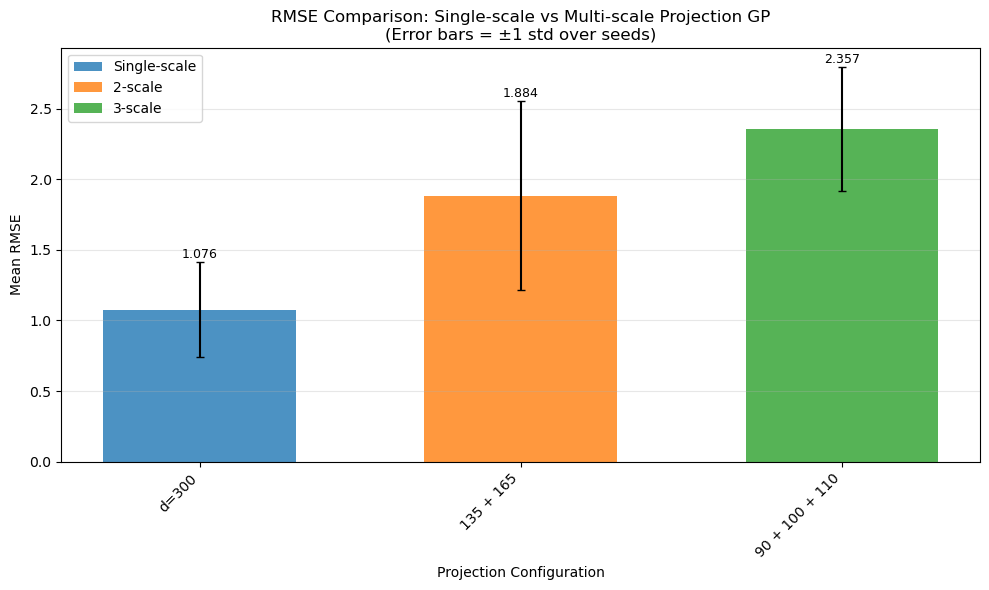


SUMMARY TABLE
      method         config  total_d  rmse_mean  rmse_std  nlpd_mean  nlpd_std
Single-scale          d=300      300   1.076333  0.335515   1.842370  0.104051
     2-scale      135 + 165      300   1.883882  0.670066   2.114953  0.219108
     3-scale 90 + 100 + 110      300   2.356761  0.435976   2.313301  0.143907


In [10]:
# Compare single-scale vs multi-scale projection GP methods
results_multiscale = plot_multiscale_comparison(
    x_train=x_train_co2,
    y_train=y_train_co2,
    x_test=x_test_co2,
    y_test=y_test_co2,
    single_scale_d=300,
    multiscale_configs=[
        [135, 165],
        [90, 100, 110]
    ],
    n_seeds=5,
    num_mixtures=2,
    cfg=TrainCfg(
        max_iter=200,
        lr=0.01,
        verbose=False,
        mean_cfg="linear"
    ),
    savepath='../results/mauna_loa_multiscale_comparison.png',
    figsize=(10, 6)
)


## Calibration and Robustness

### Reliability

Running reliability analysis with 5 seeds

running spherical GP training | iters=500 lr=0.05 d=300 jitter=0.0001
[proj ] iter=0000 loss=2202.056641 Delta=inf ||grad||=2.99e+02
noise=0.1 |raw_noise|grad=10.3136625289917
[proj ] iter=0100 loss=1435.745728 Delta=3.69e+00 ||grad||=8.16e+01
noise=0.155 |raw_noise|grad=6.694320201873779
[proj ] iter=0200 loss=1174.267456 Delta=2.02e+00 ||grad||=5.86e+01
noise=0.229 |raw_noise|grad=6.544363021850586
[proj ] iter=0300 loss=992.367188 Delta=1.27e+00 ||grad||=4.32e+01
noise=0.34 |raw_noise|grad=6.671290397644043
[proj] early stop @ 361
[proj ] done | time=27.39s best_loss=888.656799

running spherical GP training | iters=500 lr=0.05 d=300 jitter=0.0001
[proj ] iter=0000 loss=2662.588867 Delta=inf ||grad||=4.19e+02
noise=0.1 |raw_noise|grad=12.440994262695312
[proj ] iter=0100 loss=1321.482788 Delta=3.11e+00 ||grad||=7.84e+01
noise=0.151 |raw_noise|grad=6.41743803024292
[proj ] iter=0200 loss=1100.921387 Delta=1.80e+00 ||grad||=5.75e+01
noise=0.2

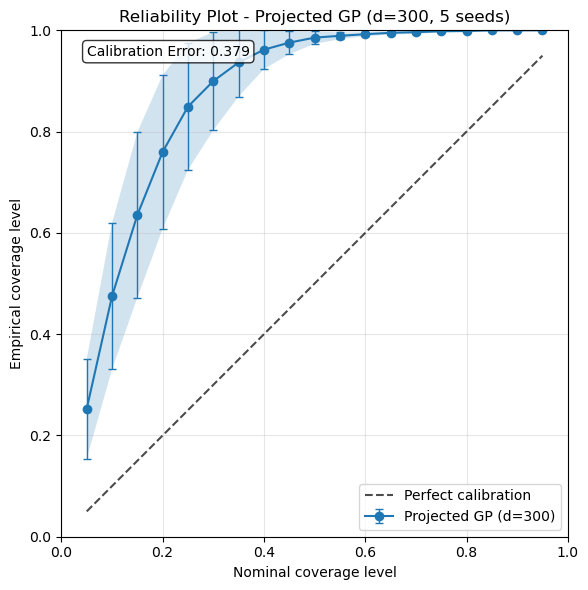

Calibration error: 0.3791


In [7]:
results = plot_reliability_projected_gp(
    x_train_co2, y_train_co2, x_test_co2, y_test_co2, num_mixtures=2,
    d_proj=300, n_seeds=5, cfg=TrainCfg(verbose=True, resample_every=20, lr=0.05, mean_cfg="linear")
)

print(f"Calibration error: {results['calibration_error']:.4f}")

### Hyperparameter stability

100%|██████████| 30/30 [13:23<00:00, 26.79s/it]


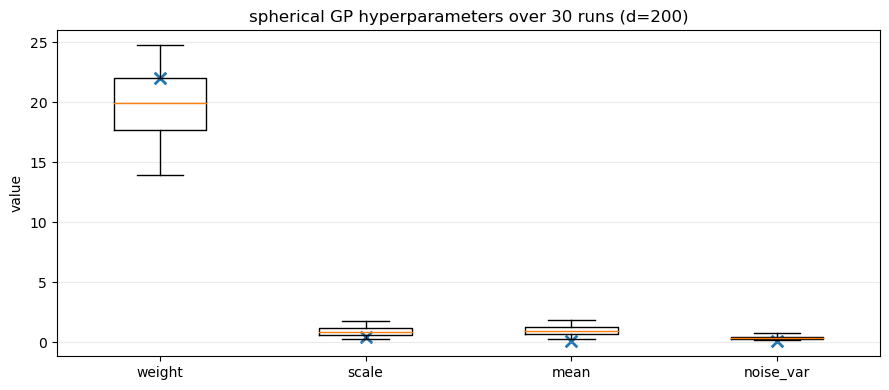

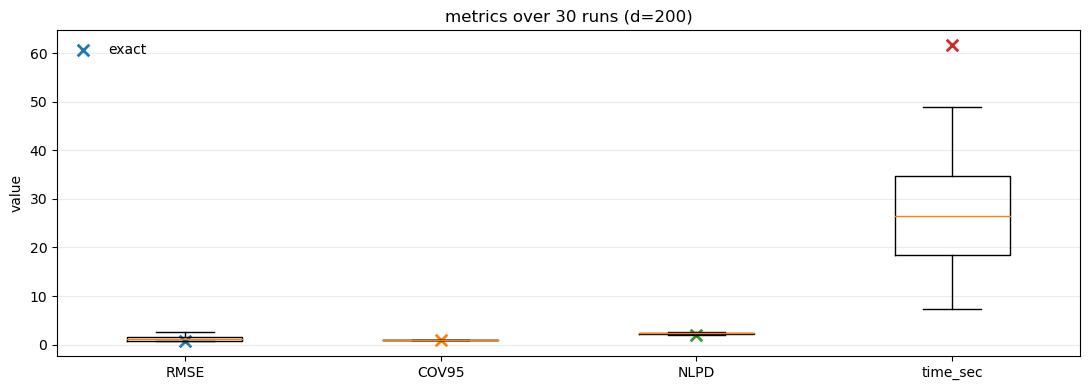

In [6]:
# analyse hyperparameter stability for a fixed d

df_hyp, df_metric, reps = repeat_spherical_runs_for_d(
    x_train_co2, y_train_co2, x_test_co2, y_test_co2,
    d=200,
    k=30,
    num_mixtures=2,
    cfg=TrainCfg(max_iter=500, patience=40, lr=0.05, verbose=False, mean_cfg="linear"),
    init_hyps_data=False,
    res_exact=res_exact_co2,
    savepath_hyp='../results/hyp_box_d200.png',
    savepath_nlpd='../results/nlpd_box_d200.png'
)
